In [ ]:
# COLAB: uncomment below to setup for Git
# !git clone https://github.com/C7082-2022/labs-cv-colab

In [ ]:
# COLAB: uncomment below to change directory
# cd labs-cv-colab/03-DL-basics

In [2]:
# setup for images
from IPython.display import Image

# Lab 06 Data augmentation

<br>


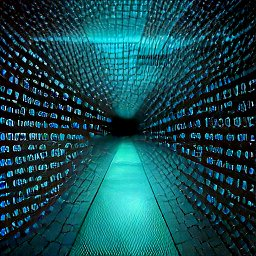

In [3]:
Image("img/craiyon-data.jpg", width = 300)
# Craiyon.com "Data augmentation" 


## 1 Objectives

Now that we've practiced the fundamentals of convolutional classifiers, we're ready to move on to more advanced topics.

In this notebook, we'll learn a tool that can give a boost to your image classifiers: 

- **data augmentation**. 

## 2 The Usefulness of Fake Data

The best way to improve the performance of a machine learning model is to train it on more data. The more examples the model has to learn from, the better it will be able to recognize which differences in images matter and which do not. More data helps the model to *generalize* better.

One easy way of getting more data is to use the data you already have. If we can transform the images in our dataset in ways that preserve the class, we can teach our classifier to ignore those kinds of transformations. For instance, whether a car is facing left or right in a photo doesn't change the fact that it is a *Car* and not a *Truck*. So, if we **augment** our training data with flipped images, our classifier will learn that "left or right" is a difference it should ignore.

And that's the whole idea behind data augmentation: add in some extra fake data that looks reasonably like the real data and your classifier will improve.

## 3 Using Data Augmentation

Typically, many kinds of transformation are used when augmenting a dataset. These might include rotating the image, adjusting the color or contrast, warping the image, or many other things, usually applied in combination. Here is a sample of the different ways a single image might be transformed.

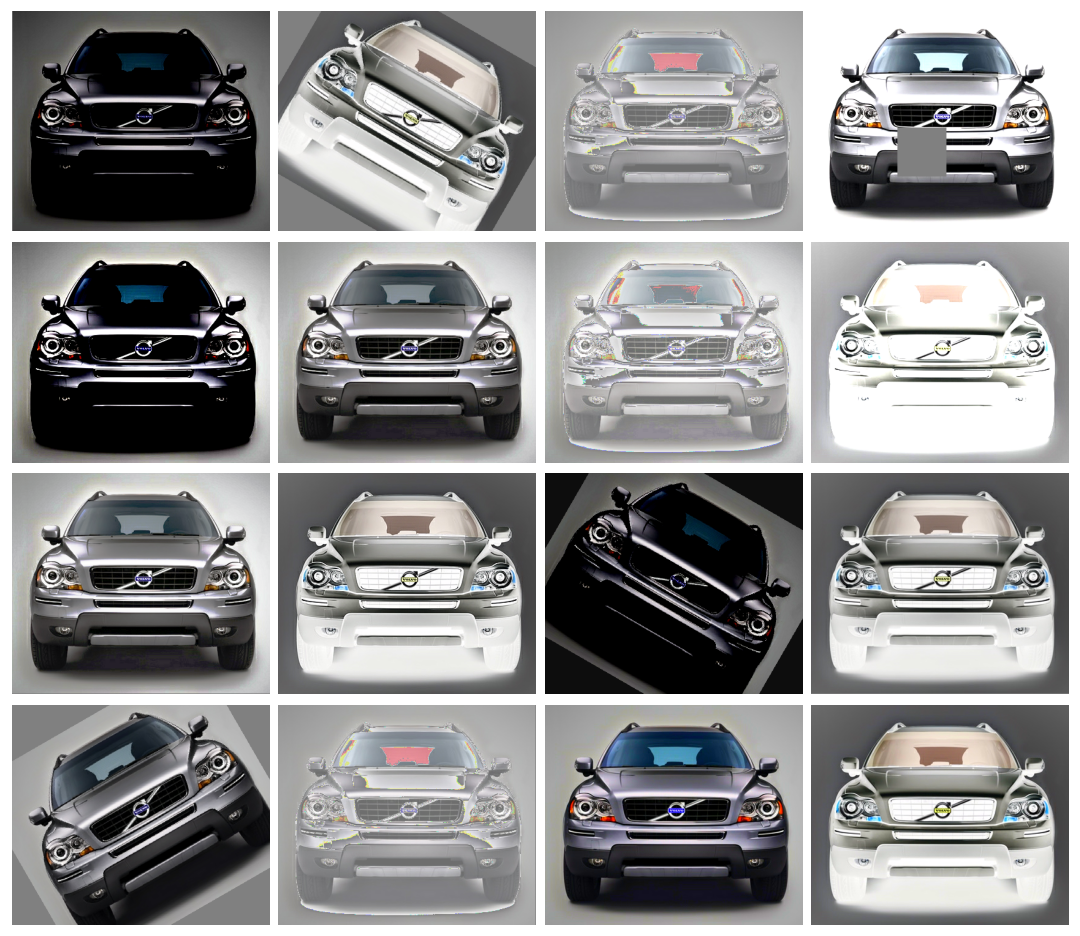

In [4]:
Image("img/6-1.png", width = 400)
# Sixteen transformations of a single image of a car

Data augmentation is usually done *online*, meaning, as the images are being fed into the network for training. Recall that training is usually done on mini-batches of data. This is what a batch of 16 images might look like when data augmentation is used.


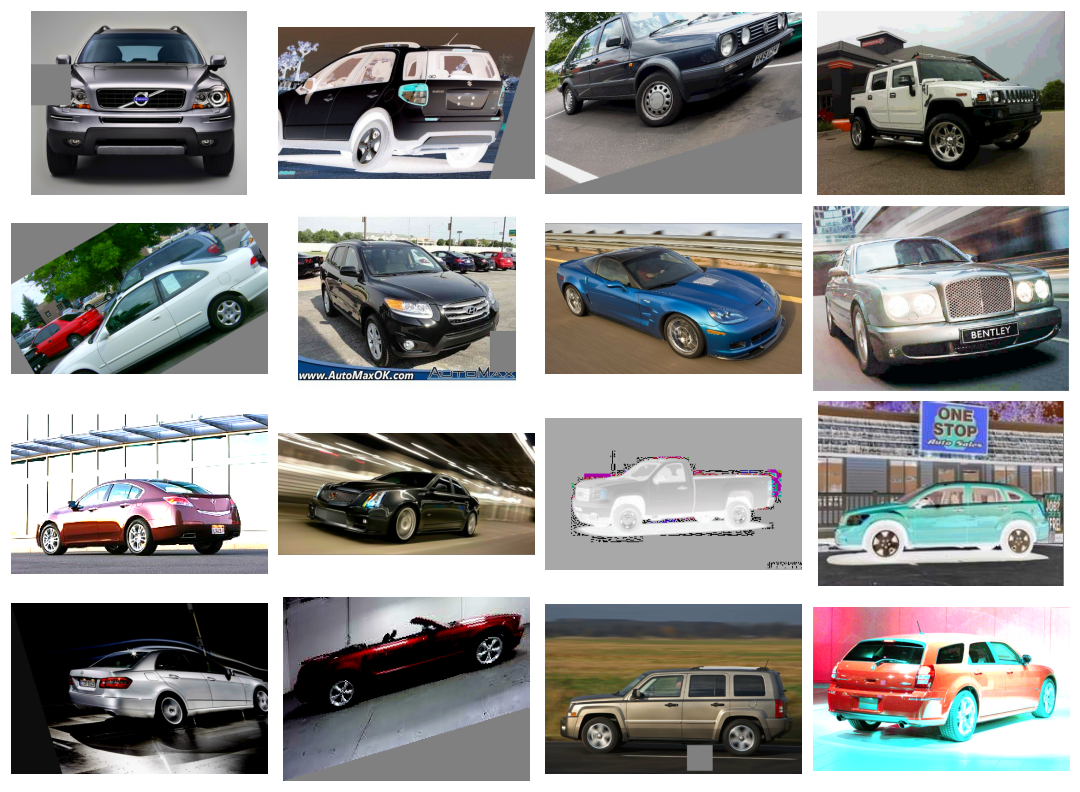

In [5]:
Image("img/6-2.png", width = 400)
# A batch of 16 images with various random transformations applied

Each time an image is used during training, a new random transformation is applied. This way, the model is always seeing something a little different than what it's seen before. This extra variance in the training data is what helps the model on new data.

It's important to remember though that not every transformation will be useful on a given problem. Most importantly, whatever transformations you use should not mix up the classes. If you were training a [digit recognizer](https://www.kaggle.com/c/digit-recognizer), for instance, rotating images would mix up '9's and '6's. In the end, the best approach for finding good augmentations is the same as with most ML problems: try it and see!



## 4 Example - Training with Data Augmentation

Keras lets you augment your data in two ways. The first way is to include it in the data pipeline with a function like [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). The second way is to include it in the model definition by using Keras's **preprocessing layers**. This is the approach that we'll take. The primary advantage for us is that the image transformations will be computed on the GPU instead of the CPU, potentially speeding up training.

### 4.1 - Setup

Here, we'll learn how to improve the classifier from Lesson 1 through data augmentation. This next hidden cell sets up the data pipeline.

In [1]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'data/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


### 4.2 - Define Model

To illustrate the effect of augmentation, we'll just add a couple of simple transformations to the model from Tutorial 1.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
# these are a new feature in TF 2.2
from tensorflow.keras.layers.experimental import preprocessing


pretrained_base = tf.keras.models.load_model(
    'data/vgg16-pretrained-base',
)
pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5), # contrast change by up to 50%
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

### 4.3 - Train and Evaluate 

And now we'll start the training!

In [5]:
# Takes a long time
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1,
)

Epoch 1/30
80/80 [==============================] - 227s 3s/step - loss: 0.5022 - binary_accuracy: 0.7573 - val_loss: 0.3898 - val_binary_accuracy: 0.8329
Epoch 2/30
80/80 [==============================] - 219s 3s/step - loss: 0.3824 - binary_accuracy: 0.8290 - val_loss: 0.3502 - val_binary_accuracy: 0.8493
Epoch 3/30
80/80 [==============================] - 219s 3s/step - loss: 0.3401 - binary_accuracy: 0.8579 - val_loss: 0.3296 - val_binary_accuracy: 0.8634
Epoch 4/30


KeyboardInterrupt: 

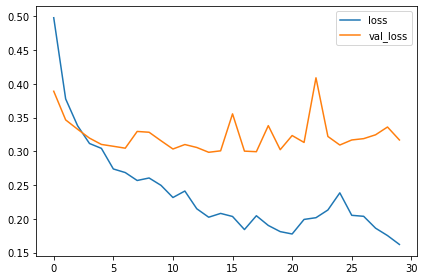

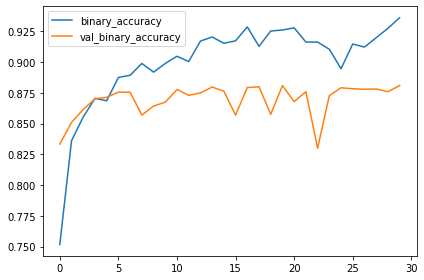

In [4]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

The training and validation curves in the model from Tutorial 1 diverged fairly quickly, suggesting that it could benefit from some regularization. The learning curves for this model were able to stay closer together, and we achieved some modest improvement in validation loss and accuracy. This suggests that the dataset did indeed benefit from the augmentation.



## 5 Objectives

In these exercises, you'll explore what effect various random transformations have on an image, consider what kind of augmentation might be appropriate on a given dataset, and then use data augmentation with the *Car or Truck* dataset to train a custom network.

Run the cell below to set everything up!

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'data/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

# AUTOTUNE don't mean Cher singing!
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


<br>

**Explore Augmentation**

Uncomment a transformation and run the cell to see what it does. You can experiment with the parameter values too, if you like. (The `factor` parameters should be greater than 0 and, generally, less than 1.) Run the cell again if you'd like to get a new random image.

In [ ]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

Do the transformations you chose seem reasonable for the *Car or Truck* dataset?

In this exercise, we'll look at a few datasets and think about what kind of augmentation might be appropriate. Your reasoning might be different that what we discuss in the solution. That's okay. The point of these problems is just to think about how a transformation might interact with a classification problem -- for better or worse.

### 5.1 EuroSAT 

The [EuroSAT](https://www.kaggle.com/ryanholbrook/eurosat) dataset consists of satellite images of the Earth classified by geographic feature. Below are a number of images from this dataset.

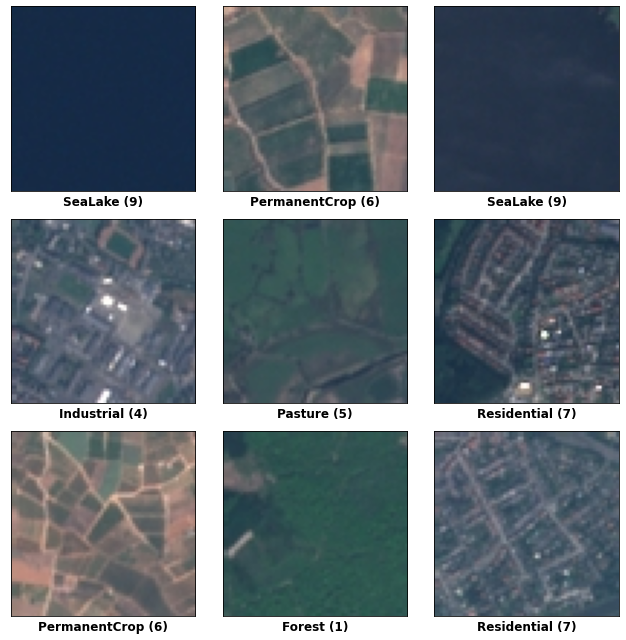

In [6]:
Image("img/6-3.png", width = 600)
# Sixteen satellite images labeled: SeaLake, PermanentCrop, Industrial, Pasture, Residential, and Forest


What kinds of transformations might be appropriate for this dataset?

### 5.2 TensorFlow Flowers

The [TensorFlow Flowers](https://www.kaggle.com/ryanholbrook/tensorflow-flowers) dataset consists of photographs of flowers of several species. Below is a sample.

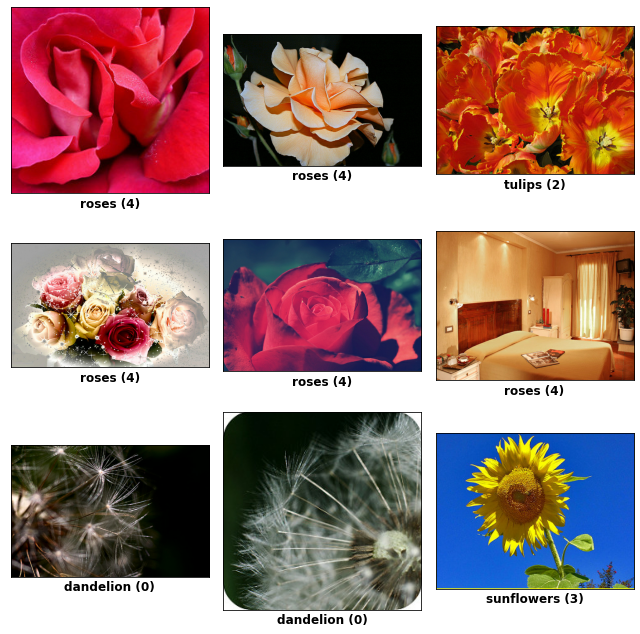

In [7]:
Image("img/6-4.png", width = 600)
# Sixteen images of flowers labeled: roses, tulips, dandelion, and sunflowers

What kinds of transformations might be appropriate for the TensorFlow Flowers dataset?

### 5.3 Add Preprocessing Layers

Now you'll use data augmentation with a custom convnet. Since data augmentation effectively increases the size of the dataset, we can increase the capacity of the model in turn without as much risk of overfitting.

Add these preprocessing layers to the given model.

```
preprocessing.RandomContrast(factor=0.10),
preprocessing.RandomFlip(mode='horizontal'),
preprocessing.RandomRotation(factor=0.10),
```


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    # ____,

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])



<br>

Now we'll train the model. Run the next cell to compile it with a loss and accuracy metric and fit it to the training set.

In [ ]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

### 5.4 Train Model

Examine the training curves. What there any sign of overfitting? How does the performance of this model compare to other models you've trained in this course?

**Conclusion**

Data augmentation is a powerful and commonly-used tool to improve model training, not only for convolutional networks, but for many other kinds of neural network models as well. Whatever your problem, the principle remains the same: you can make up for an inadequacy in your data by adding in "fake" data to cover it over. Experimenting with augmentations is a great way to find out just how far your data can go!